In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils.fixes import sp_version, parse_version
from sklearn.model_selection import KFold
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv("C:\\Users\\Lama\\Desktop\\conformal_prediction\\Advertising.csv")
X = data["TV"].values.reshape(-1, 1)
y = data["Sales"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Jacknife sur la regression quantile linéaire 90%

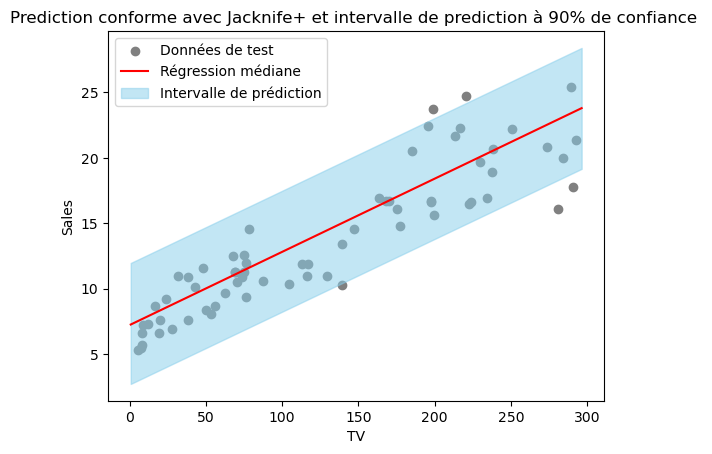

In [3]:
qr_med = QuantileRegressor(quantile=0.5, alpha=0, solver='highs').fit(X_train, y_train)

def score_jacknife(model, x_new, x_cal, y_cal):
    x_new_2d = x_new.reshape(1, -1)  # Assurez-vous que x_new soit en 2D
    score_plus = model.predict(x_new_2d) + np.abs(y_cal - model.predict(x_cal))
    score_moins = model.predict(x_new_2d) - np.abs(y_cal - model.predict(x_cal))
    return np.array([score_moins, score_plus]).T

def pred_conf_jackknife(x_new, X, Y, alpha):
    qr_med = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
    scores = np.empty([len(X), 2])
    for i in range(len(X)):
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(Y, i)
        model = qr_med.fit(X_train, y_train)
        scores[i] = score_jacknife(model, x_new, X[i].reshape(1, -1), Y[i])
    return np.quantile(scores[:, 0], q=alpha/2), np.quantile(scores[:, 1], q=1-alpha/2)

def create_up_low_bounds_jackknife(X, Y, n_steps, alpha):
    x_low = np.min(X)
    x_up = np.max(X)
    x_new = np.linspace(x_low, x_up, n_steps).reshape(-1, 1)
    bounds = np.empty([n_steps, 2])
    for i, x in enumerate(x_new):
        bounds[i] = pred_conf_jackknife(x, X, Y, alpha)
    return bounds

# Calculer les bornes avec Jackknife
bounds = create_up_low_bounds_jackknife(X_train, y_train, n_steps=100, alpha=0.1)


plt.scatter(X_test, y_test, color='grey', label='Données de test')
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = qr_med.predict(x_range)
plt.plot(x_range, y_range, color='red', label='Régression médiane')
plt.fill_between(x_range.flatten(), bounds[:, 0], bounds[:, 1], color='skyblue', alpha=0.5, label='Intervalle de prédiction')
plt.title('Prediction conforme avec Jacknife+ et intervalle de prediction à 90% de confiance ')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.legend()
plt.show()

# cv+ sur la regression quantile linéaire 95%

In [4]:
n_splits = 5
folder = KFold(n_splits = n_splits)
F = folder.get_n_splits(X)

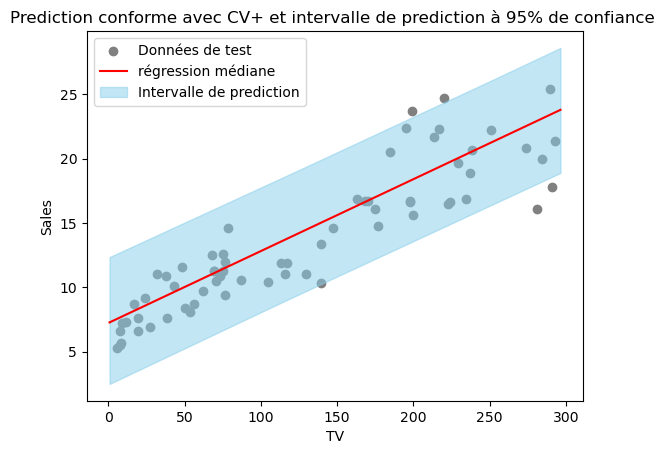

In [5]:
qr_med = QuantileRegressor(quantile=0.5, alpha=0, solver='highs').fit(X_train, y_train)

def score_cv(model, x_new, x_cal, y_cal):
    x_new_2d = x_new.reshape(1, -1)  # Assurez-vous que x_new soit en 2D
    score_plus = model.predict(x_new_2d) + np.abs(y_cal - model.predict(x_cal))
    score_moins = model.predict(x_new_2d) - np.abs(y_cal - model.predict(x_cal))
    return np.array([score_moins, score_plus]).T

def pred_conf_cv(x_new, X, Y, KFolder, alpha):
    qr_med = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
    scores = np.empty([len(X), 2])
    j = 0
    for i, (train_set, cal_set) in enumerate(KFolder.split(X)):
        model = qr_med.fit(X[train_set], Y[train_set])
        x_new_2d = x_new.reshape(1, -1)  # Assurez-vous que x_new soit en 2D
        scores[j:j + len(cal_set)] = score_cv(model, x_new_2d, X[cal_set], Y[cal_set])
        j += len(cal_set)
    return np.quantile(scores[:, 0], q=alpha/2), np.quantile(scores[:, 1], q=1-alpha/2)

def create_up_low_bounds_cv(X, Y, n_splits, n_steps, alpha):
    x_low = np.min(X)
    x_up = np.max(X)
    x_new = np.linspace(x_low, x_up, n_steps).reshape(-1, 1)
    bounds = np.empty([n_steps, 2])
    KFolder = KFold(n_splits=n_splits)
    for i, x in enumerate(x_new):
        bounds[i] = pred_conf_cv(x, X, Y, KFolder, alpha)
    return bounds

bounds = create_up_low_bounds_cv(X_train, y_train, n_splits=5, n_steps=100, alpha=0.05)


#plt.scatter(X_train, y_train, color='blue', label='Données d’entraînement')
plt.scatter(X_test, y_test, color='grey', label='Données de test')

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = qr_med.predict(x_range)
plt.plot(x_range, y_range, color='red', label='régression médiane')

plt.fill_between(x_range.flatten(), bounds[:, 0], bounds[:, 1], color='skyblue', alpha=0.5, label='Intervalle de prediction')
plt.title('Prediction conforme avec CV+ et intervalle de prediction à 95% de confiance ')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.legend()
plt.show()
